# FROM SENTIMENT ANALYSIS TO EMOTION RECOGNITION

Notebook 2 -> Sentiment Analysis Good Data


In [ ]:
# Mount Drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearning_2020/Final_Project/Data/'
data_path = '/content/drive/My Drive/DeepLearning_2020/Final_Project/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2020/Final_Project/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 0_test_geri.ckpt      'Task 1'		   twitter-2016test-A.txt
 5_test_geri.ckpt       test.txt	   twitter-2016train-A.txt
 Emotion_Dataset.txt    text_emotion.csv
 sentiment_tweets.csv   train.txt


Necessary imports

In [ ]:
import csv
import numpy as np
from collections import Counter 
from string import punctuation
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


Load the data

In [ ]:
def read_file(file):
    tweets = [] 
    labels = []
    dataframe = pd.read_csv(data_path + file)
    tweets = dataframe['text'].tolist()
    labels = dataframe[['NEG', 'NEU', 'POS']].to_numpy()
    labels = labels.argmax(1).tolist()
    return tweets, labels
  
tweets_file = 'sentiment_tweets.csv'
tweets, labels = read_file(tweets_file)

Display the distribution of the data

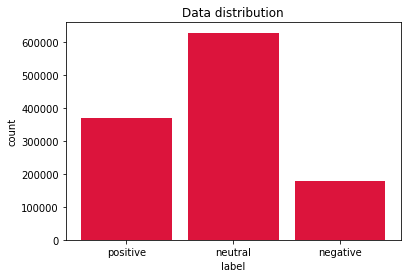

In [ ]:
labels2 = ['positive' if label == 2 else 'negative' if label == 0 else 'neutral' for label in labels]
plt.hist(labels2, bins = range(4), color = 'crimson', rwidth = 0.85, align = 'left')
plt.title('Data distribution')
plt.xlabel('label')
plt.ylabel('count')
plt.savefig(results_path + 'SA_GoodData_Dist.png')
plt.show()

Preprocess tweets

In [ ]:
# Remove Punctuation and get all the tweets from review dataset
def remove_punctutation(tweets): 
  
    all_tweets = []
    for text in tweets:
        text = text.lower()
        text = "".join([ch for ch in text if ch not in punctuation])
        all_tweets.append(text)
    all_text = " ".join(all_tweets)
    all_words = all_text.split(' ')
    
    # Remove web addresse and user handles
    new_tweets = []
    for tweet in all_tweets:
      #tweet = tweet.split()
      new_text = []
      for word in tweet.split(' '):
        if(len(word) > 0):
          if (word[0] != '@') & ('http' not in word) & (~word.isdigit()):
              new_text.append(word)
              
      new_tweets.append(new_text)
    return all_words, new_tweets

# Count all the words and sort it based on counts
def count_sort(all_words):
    count_words = Counter(all_words)
    total_words = len(all_words)
    sorted_words = count_words.most_common(total_words)
    return sorted_words

# Create a dictionary to convert words to Integers based on the number of occurrence of the word
def to_dictionary(sorted_words):
    vocab_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words)}
    return vocab_to_int

# Encode tweets in to list of Integer by using above dictionary
def encode_tweets(all_tweets, vocab_to_int):
    encoded_tweets = list()
    for tweet in all_tweets:
        encoded_tweet = list()
        
        for word in tweet:
            if word not in vocab_to_int.keys():
            #if word is not available in vocab_to_int put 0 in that place
                encoded_tweet.append(0)
            else:
                encoded_tweet.append(vocab_to_int[word])
        encoded_tweets.append(encoded_tweet)

    return encoded_tweets


# Make all the encoded_review of the same length
def get_features(encoded_tweets):
    sequence_length = 250
    features = np.zeros((len(encoded_tweets), sequence_length), dtype = int)
    for i, tweet in enumerate(encoded_tweets):
        tweet_len = len(tweet)
        if (tweet_len <= sequence_length):
            zeros = list(np.zeros(sequence_length - tweet_len))
            new = zeros + tweet
        else:
            new = tweet[:sequence_length]

        features[i, :] = np.array(new)

    return features


# Perform all pre-processing of the data
def preprocess_data(tweets):
    all_words, all_tweets = remove_punctutation(tweets)
    sorted_words = count_sort(all_words)
    vocab_to_int = to_dictionary(sorted_words)
    encoded_tweets = encode_tweets(all_tweets, vocab_to_int)
    features = get_features(encoded_tweets)
    return features, vocab_to_int

text, vocab_to_int = preprocess_data(tweets)

Split the dataset into training and testing


*   Training -> 90 %
*   Testing -> 10 %



In [ ]:
# split data into training and test data (features and labels)
split_frac = 0.9

split_idx = int(len(labels)*split_frac)
features_train, features_test = text[:split_idx], text[split_idx:]
labels_train, labels_test = labels[:split_idx], labels[split_idx:]

# print out the shapes of your resultant feature data
print("Feature Shapes:")
print("Train set: {}".format(features_train.shape), 
      "\nTest set: {}".format(features_test.shape))

Feature Shapes:
Train set: (1061961, 250) 
Test set: (117996, 250)


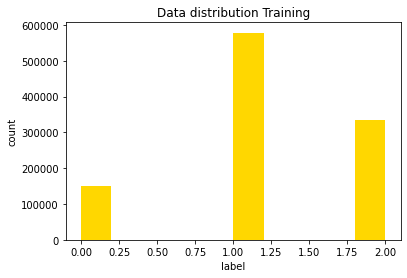

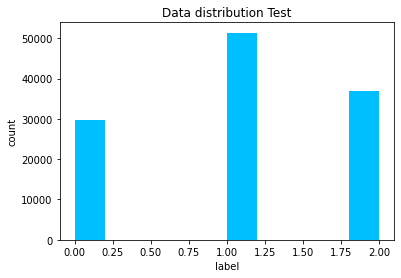

In [ ]:
plt.hist(labels_train, color = 'gold')
plt.title('Data distribution Training')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

plt.hist(labels_test, color = 'deepskyblue')
plt.title('Data distribution Test')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

Transform the data into tensors and the corresponding data loader 

In [ ]:
# Create Tensor Dataset
train_data = TensorDataset(torch.LongTensor(features_train), torch.LongTensor(labels_train))
test_data = TensorDataset(torch.LongTensor(features_test), torch.LongTensor(labels_test))

# Create data loader
batch_size = 128
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True, drop_last = True)

## Network 1

Define the architecture

In [ ]:
class SentimentLSTM1(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        #dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        #Linear and sigmoid layer
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, output_size)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size()*3
        
        #Embadding and LSTM output
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)

        sm_out = self.softmax(out)
        
        B = torch.Size([batch_size[0], batch_size[1], output_size])
        sm_out = sm_out.view(B, -1)
        sm_out = sm_out[:, -1]
        
        return sm_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Create the network

In [ ]:
# Model hyperparameters
vocab_size = len(vocab_to_int) + 1 
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentLSTM1(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2)
print('Network architecture')
print(net)

Network architecture
SentimentalLSTM(
  (embedding): Embedding(2301238, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


### Train the network

In [ ]:
model_name = '_SA_GoodData_Net1.ckpt'

# loss and optimization functions
criterion = nn.CrossEntropyLoss() 

learning_rate = .01
momentum = .9
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params
epochs = 5 
clip = 5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

losses_list = []
net.train()

# initialize hidden state
h = net.init_hidden(batch_size)

# train for some number of epochs
for e in range(epochs):
    loss_avg = 0
    nBatches = 0
    # batch loop
    total_step = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader):
        
        if(train_on_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        loss_avg += loss.cpu().item()
        nBatches += 1

        if i % 100 == 0:
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}/{}...".format(i, total_step),
                  "Loss: {:.6f}...".format(loss.item()))
    losses_list.append(loss_avg / nBatches)

    if((e + 1) % 5 == 0 and e != 0):
        plt.plot(losses_list, color = 'darkviolet')
        plt.savefig(results_path + str(e) + '_SA_GoodData_Loss_Net1.png')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        torch.save(net.state_dict(), results_path + str(e) + model_name)

Epoch: 1/5... Step: 0/8296... Loss: 1.109908...


RuntimeError: ignored

### Test the network

In [ ]:
test_losses = [] # track loss
num_correct = 0
# init hidden state
h = net.init_hidden(batch_size)

y_true = []
y_pred = []

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    y_true.append(labels.numpy())
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.long())
    test_losses.append(test_loss.item())
    
    pred = output.argmax(1) 
    y_pred.append(pred.cpu().numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.long().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.596
Test accuracy: 0.954


Display the confusion matrix

Confusion matrix:
 [[26961  1544  1129]
 [  611 50003   700]
 [  483   801 35656]]


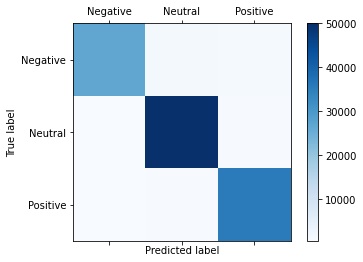

In [ ]:
Y_True = np.concatenate(y_true, axis = 0)
Y_Pred = np.concatenate(y_pred, axis = 0)

conf_mat = confusion_matrix(y_true = Y_True, y_pred = Y_Pred)
print('Confusion matrix:\n', conf_mat)

labels_conf = ['Negative', 'Neutral', 'Positive']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap = plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_conf)
ax.set_yticklabels([''] + labels_conf)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig(results_path + 'SA_GoodData_ConfusionMatrix_Net1.png')
plt.show()

## Network 2

Define the architecture

In [ ]:
class SentimentLSTM2(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        #dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        #Linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size()*3
        
        #Embadding and LSTM output
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc(out)

        sm_out = self.softmax(out)
        
        B = torch.Size([batch_size[0], batch_size[1], output_size])
        sm_out = sm_out.view(B, -1)
        sm_out = sm_out[:, -1]
        
        return sm_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Create the network

In [ ]:
# Model hyperparameters
vocab_size = len(vocab_to_int) + 1 
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentLSTM2(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.2)
print('Network architecture')
print(net)

Network architecture
SentimentalLSTM(
  (embedding): Embedding(2301238, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


### Train the network

Epoch: 1/5... Step: 0/8296... Loss: 1.097152...
Epoch: 1/5... Step: 100/8296... Loss: 0.939627...
Epoch: 1/5... Step: 200/8296... Loss: 0.835110...
Epoch: 1/5... Step: 300/8296... Loss: 0.787108...
Epoch: 1/5... Step: 400/8296... Loss: 0.802375...
Epoch: 1/5... Step: 500/8296... Loss: 0.739807...
Epoch: 1/5... Step: 600/8296... Loss: 0.794452...
Epoch: 1/5... Step: 700/8296... Loss: 0.781398...
Epoch: 1/5... Step: 800/8296... Loss: 0.796022...
Epoch: 1/5... Step: 900/8296... Loss: 0.827705...
Epoch: 1/5... Step: 1000/8296... Loss: 0.767407...
Epoch: 1/5... Step: 1100/8296... Loss: 0.825306...
Epoch: 1/5... Step: 1200/8296... Loss: 0.828133...
Epoch: 1/5... Step: 1300/8296... Loss: 1.153000...
Epoch: 1/5... Step: 1400/8296... Loss: 1.215496...
Epoch: 1/5... Step: 1500/8296... Loss: 1.262371...
Epoch: 1/5... Step: 1600/8296... Loss: 1.192055...
Epoch: 1/5... Step: 1700/8296... Loss: 1.270178...
Epoch: 1/5... Step: 1800/8296... Loss: 1.160801...
Epoch: 1/5... Step: 1900/8296... Loss: 1.25

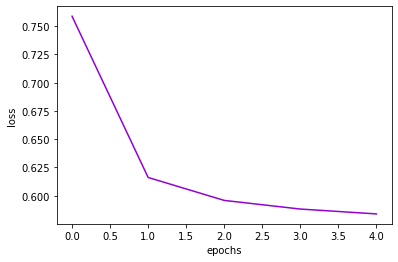

In [ ]:
model_name = '_SA_GoodData_Net2.ckpt'

# loss and optimization functions

criterion = nn.CrossEntropyLoss() 

learning_rate = .1
momentum = .9
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params
epochs = 5 
clip = 5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

losses_list = []
net.train()

# initialize hidden state
h = net.init_hidden(batch_size)

# train for some number of epochs
for e in range(epochs):
    loss_avg = 0
    nBatches = 0
    # batch loop
    total_step = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader):
        
        if(train_on_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        loss_avg += loss.cpu().item()
        nBatches += 1

        if i % 100 == 0:
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}/{}...".format(i, total_step),
                  "Loss: {:.6f}...".format(loss.item()))
    losses_list.append(loss_avg / nBatches)

    if((e + 1) % 5 == 0 and e != 0):
        plt.plot(losses_list, color = 'darkviolet')
        plt.savefig(results_path + str(e) + '_SA_GoodData_Loss_Net2.png')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        torch.save(net.state_dict(), results_path + str(e) + model_name)

### Test the network

In [ ]:
test_losses = [] # track loss
num_correct = 0
# init hidden state
h = net.init_hidden(batch_size)

y_true = []
y_pred = []

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    y_true.append(labels.numpy())
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.long())
    test_losses.append(test_loss.item())
    
    pred = output.argmax(1) 
    y_pred.append(pred.cpu().numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.long().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.589
Test accuracy: 0.961


Display the confusion matrix

Confusion matrix:
 [[27468  1296   860]
 [  561 50307   452]
 [  536   765 35643]]


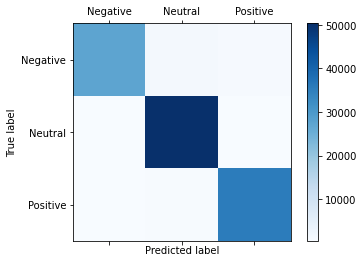

In [ ]:
Y_True = np.concatenate(y_true, axis = 0)
Y_Pred = np.concatenate(y_pred, axis = 0)

conf_mat = confusion_matrix(y_true = Y_True, y_pred = Y_Pred)
print('Confusion matrix:\n', conf_mat)

labels_conf = ['Negative', 'Neutral', 'Positive']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap = plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_conf)
ax.set_yticklabels([''] + labels_conf)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig(results_path + 'SA_GoodData_ConfusionMatrix_Net2.png')
plt.show()